In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [137]:
#Reading Data from CSV
cleanedData = pd.read_csv('Data/cleaned_data.csv')
cleanedData.head()

,apmc,commodity,year,month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name
0,ahmednagar,bajri,2015,april,79,1406,1538,1463,2015-04-01,ahmadnagar,maharashtra
1,ahmednagar,bajri,2016,april,106,1788,1925,1875,2016-04-01,ahmadnagar,maharashtra
2,ahmednagar,wheathusked,2015,april,1253,1572,1890,1731,2015-04-01,ahmadnagar,maharashtra
3,ahmednagar,wheathusked,2016,april,387,1750,2220,1999,2016-04-01,ahmadnagar,maharashtra
4,ahmednagar,sorgumjawar,2015,april,3825,1600,2200,1900,2015-04-01,ahmadnagar,maharashtra


In [138]:
cleanedData.date = pd.to_datetime(cleanedData.date)
cleanedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55787 entries, 0 to 55786
Data columns (total 11 columns):
apmc               55787 non-null object
commodity          55787 non-null object
year               55787 non-null int64
month              55787 non-null object
arrivals_in_qtl    55787 non-null int64
min_price          55787 non-null int64
max_price          55787 non-null int64
modal_price        55787 non-null int64
date               55787 non-null datetime64[ns]
district_name      55787 non-null object
state_name         55787 non-null object
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 4.7+ MB


In [175]:
#fuction for stationarity test of a timeseries
'''
Parameters
    - timeseries: Time series 
    Note - Function raises exception if time series has less than 12 data points. 
'''
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    try:
        if len(timeseries)<12:
            raise ValueError('Insufficent data to test stationarity')
        timeseries = pd.DataFrame(timeseries.replace([np.inf, -np.inf], np.nan))
        timeseries = timeseries.fillna(method='ffill')
        timeseries = timeseries.iloc[:, 0]
        timeseries.replace([np.inf, -np.inf], np.nan).dropna()
        #Determing rolling statistics
        rolmean = timeseries.rolling(4).mean()
        rolstd = timeseries.rolling(4).std()

        #Plot rolling statistics:
        orig = timeseries.plot(color='blue',label='Original')
        mean = rolmean.dropna().plot(color='red', label='Rolling Mean')
        std = rolstd.dropna().plot(color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show()

        #Perform Dickey-Fuller test:
        X = timeseries.values
        result = adfuller(X,1)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
    except ValueError as ve:
        print(ve)

In [176]:
# grouping data by apmc and commodity 
groupbyApmcAndCommodity = cleanedData.groupby(['apmc','commodity'])['modal_price','date']

In [177]:
#fuction to create time series for APMC and commodity
'''
Parmeters 
 - apmcName -  Name of the APMC
 - commodityName - Name of the commodity in that APMC
'''
def get_timeseries(apmcName, commodityName):
    apmcAndCommodityFrame = groupbyApmcAndCommodity.get_group((apmcName,commodityName))
    apmcAndCommodityFrame.set_index('date', inplace=True)
    timeseries = apmcAndCommodityFrame['modal_price']
    timeseries.plot()
    plt.title(commodityName + ' prices in ' + apmcName + ' APMC')
    return timeseries

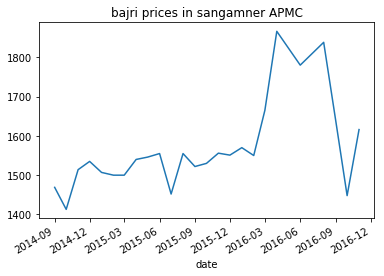

In [178]:
timeseries = get_timeseries('sangamner','bajri')

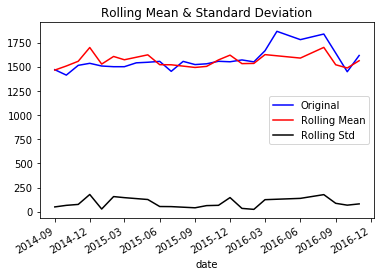

ADF Statistic: -2.545854
p-value: 0.104712
Critical Values:
	1%: -3.753
	5%: -2.998
	10%: -2.639


In [179]:
test_stationarity(timeseries)

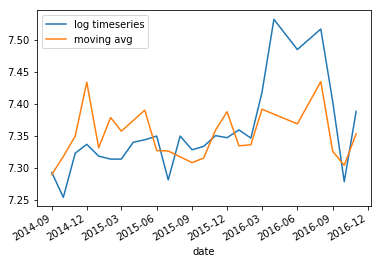

In [180]:
#reducing trend in timeseries
timeseries_log = np.log(timeseries)
moving_avg = timeseries_log.rolling(4).mean()
timeseries_log.plot(label='log timeseries')
moving_avg.dropna().plot(label='moving avg')
ts_log_moving_avg_diff = timeseries_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
plt.legend(loc='best')

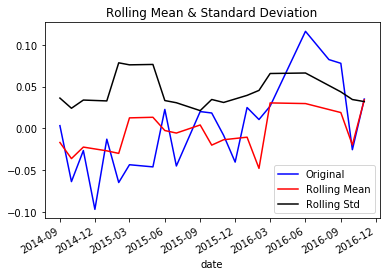

ADF Statistic: -5.080288
p-value: 0.000015
Critical Values:
	1%: -3.788
	5%: -3.013
	10%: -2.646


In [181]:
test_stationarity(ts_log_moving_avg_diff)

additive


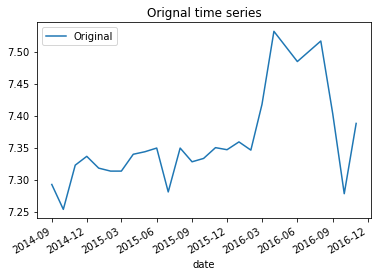

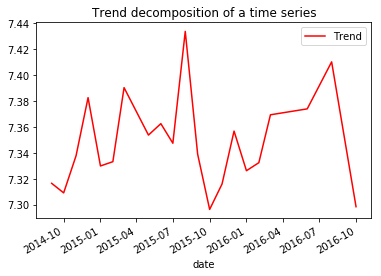

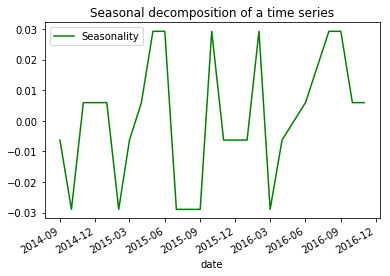

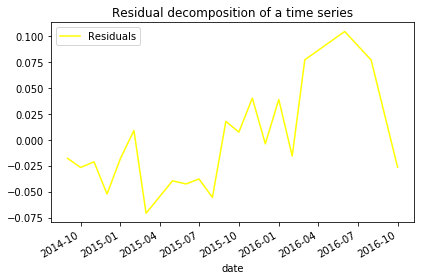

In [182]:
#Decomposing Time series in Trend, Seasonal and Residual components
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(timeseries_log,model='additive',freq=4)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend.dropna(inplace=True)
seasonal.dropna(inplace=True)
residual.dropna(inplace=True)

plt.figure()
timeseries_log.plot(label='Original')
plt.legend(loc='best')
plt.title('Orignal time series')

plt.figure()
trend.dropna().plot(label='Trend',color='red')
plt.legend(loc='best')
plt.title('Trend decomposition of a time series')

plt.figure()
seasonal.dropna().plot(label='Seasonality',color='green')
plt.legend(loc='best')
plt.title('Seasonal decomposition of a time series')

plt.figure()
residual.dropna().plot(label='Residuals',color='yellow')
plt.legend(loc='best')
plt.title('Residual decomposition of a time series')
plt.tight_layout()

add_val = trend + seasonal + residual
add_val.dropna(inplace=True)

if (add_val-timeseries_log).dropna().all() == 0:
    print("additive")
else:
    print("Mulitplicative")

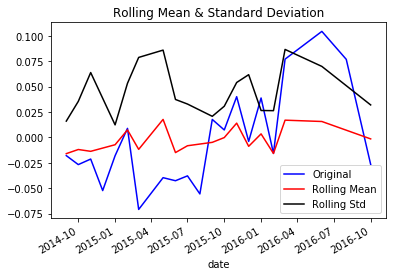

ADF Statistic: -6.767319
p-value: 0.000000
Critical Values:
	1%: -3.833
	5%: -3.031
	10%: -2.656


In [183]:
# Testing stationarity for residual component of timeseries
tsimeseriesLogDecompose = residual
test_stationarity(tsimeseriesLogDecompose)

In [184]:
# Finding optimal parameters for the model
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima_model import ARMA
aiclist = []
paramList = []
for p in range(1,3):
    for d in range(2):
        for q in range(3):
            try:
                arima_mod=ARMA(timeseries,(p,d,q)).fit(transparams=True)
                x=arima_mod.aic
                x1= p,d,q
                aiclist.append(x)
                paramList.append(x1)
                aic.append(x)
                pdq.append(x1)
            except:
                pass
            
param = paramList[aiclist.index(min(aiclist))]

# fit model
model = ARMA(timeseries,order=param)
model_fit = model.fit(display=-1)
print(param)

#Now we can predict the future values using predict method

(2, 0, 0)


In [185]:
#Reading msp prices CSV file 
msp = pd.read_csv('Data/cleaned_msp.csv')
display(msp.info())
msp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 5 columns):
commodity     145 non-null object
year          145 non-null int64
type          145 non-null object
msprice       145 non-null float64
msp_filter    145 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ KB


None

,commodity,year,type,msprice,msp_filter
0,paddyunhusked,2012,kharifcrops,1250.0,1
1,ricepaddyhus,2012,kharifcrops,1280.0,1
2,jowarhybrid,2012,kharifcrops,1500.0,1
3,sorgumjawar,2012,kharifcrops,1520.0,1
4,bajri,2012,kharifcrops,1175.0,1


In [186]:
msp.year = pd.to_datetime(msp.year,format='%Y')
msp['msprice'] = msp['msprice'].astype(int)

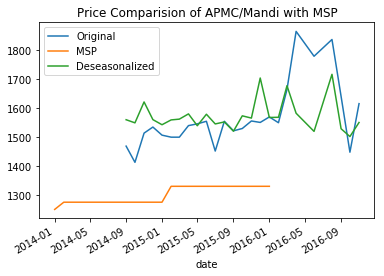

In [187]:
# Grouping msp prices by commodity
mspGroupbyCommodity = msp.groupby('commodity')['msprice','year']

# Creating Time series for each commodity
mspFrameGroupbyCommodity = mspGroupbyCommodity.get_group('bajri')
msp.year = pd.to_datetime(msp.year,format='%Y')

mspFrameGroupbyCommodity.set_index('year', inplace=True)
mspTimeseries = mspFrameGroupbyCommodity['msprice']

mspTimeseries = mspTimeseries.resample('MS').fillna(method='bfill')

timeseries.plot(label='Original')
mspTimeseries[('2014'):].plot(label='MSP')
model_fit.fittedvalues.plot(label='Deseasonalized')
plt.title('Price Comparision of APMC/Mandi with MSP')
plt.legend(loc='best')